## Import

In [1]:
import os
#import json
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = "../phenotype_classification/output_phenotypes"

In [3]:
path = 'output'
output_path = os.path.join(path, 'infl_vs_ign')

## Load

In [4]:
adata = sc.read_h5ad(os.path.join(input_path, 'sc_phenotypes_unif_annotation.h5ad'))

In [5]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_short'
tissue_region_key = 'tumor_source'

In [6]:
# exclude normal from analysis
adata_region = adata[adata.obs[tissue_region_key].isin(['core', 'border'])].copy()

In [7]:
# exclude phenotype ignored from analysis
adata = adata_region[adata_region.obs[phenotype_key].isin(['inflamed', 'ignored'])].copy()

In [8]:
# raw counts for deseq2
adata.X = adata.layers['counts'].copy()

In [9]:
adata.obs[cell_type_key].value_counts()

celltype
Cancer cell         9166
Neutrophil          7302
T cell              6617
Plasma cell         2415
Macrophage          1563
B cell              1164
Endothelial cell     701
Fibroblast           406
Dendritic cell       231
Mast cell            183
Epithelial cell      132
Schwann cell          10
Name: count, dtype: int64

## All cells

### Counts dataframe

In [10]:
adata.obs['patient_phenotype'] = (adata.obs[patient_key].astype(str) + " - " + adata.obs[phenotype_key].astype(str))
adata.obs['patient_phenotype'] = adata.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata.X.todense() if hasattr(adata.X, "todense") else adata_cancer.X, 
                             columns=adata.var['GeneSymbol'], 
                             index=adata.obs_names)

counts_cancer['patient_phenotype'] = adata.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [11]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 15065


### Metadata dataframe

In [12]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].astype('category')

metadata_cancer = adata.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [13]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [14]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.75 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 3.41 seconds.

Fitting LFCs...
... done in 2.18 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [183]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [15]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'ignored'], inference=inference)
stat.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs ignored
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneSymbol                                                              
A1CF         947.608202       -1.593290  0.893418 -1.783366  0.074527   
A2M         2583.592977       -0.021231  0.531295 -0.039960  0.968125   
A2M-AS1       16.300709        0.373955  1.693489  0.220819  0.825233   
A4GALT        80.290799        0.539011  0.913035  0.590351  0.554955   
AAAS         644.361817       -0.234162  0.415746 -0.563234  0.573276   
...                 ...             ...       ...       ...       ...   
ZXDC        1328.569619        0.473742  0.397270  1.192495  0.233067   
ZYG11B      1192.248900       -0.239279  0.364754 -0.656000  0.511824   
ZYX         2779.296409        0.399768  0.419760  0.952372  0.340908   
ZZEF1        768.613664        0.889415  0.428720  2.074582  0.038025   
ZZZ3        1416.668866        0.121957  0.260914  0.467

... done in 1.40 seconds.



In [16]:
results = stat.results_df

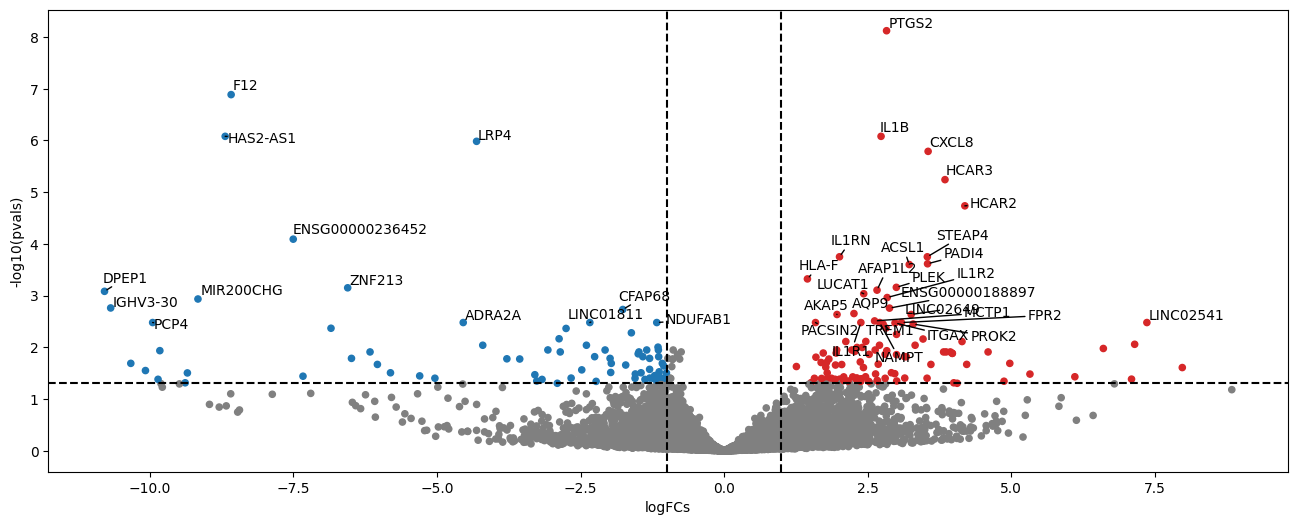

In [19]:
dc.plot_volcano_df(
    results,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=40,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [18]:
results.to_csv(os.path.join(output_path, "de_results.csv"), index=True)